### Import packages & load data

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import filtfilt, butter
from scipy.ndimage import binary_closing, binary_opening

from utils import extract_features, decompose_segment, segment_column, remove_artifacts_from_column, bandpass, synchronize_trials, top_bot_25, z_normalize_column, train

eeg_data_1 = pd.read_csv('data/subject2/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv('data/subject2/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv('data/subject2/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv('data/subject2/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv('data/subject2/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv('data/subject2/gradcpt-session1-3.csv')

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

### Syncrhonize the start times of the EEG and GradCPT data

In [2]:
eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

eeg_data_1['AF8_normal'] = z_normalize_column(eeg_data_1['AF8'])
eeg_data_2['AF8_normal'] = z_normalize_column(eeg_data_2['AF8'])
eeg_data_3['AF8_normal'] = z_normalize_column(eeg_data_3['AF8'])


# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

Gradcpt data had to be truncated
Gradcpt data had to be truncated


In [3]:
# Remove other channels
channels = ['timestamps', 'AF8_normal', 'trial']
af8 = eeg_data[channels].copy()

### Artifact removal

In [4]:
af8['AF8_artif_removed'] = remove_artifacts_from_column(af8['AF8_normal'])

### Bandpass filtering

In [5]:
af8['AF8_bandpassed'] = bandpass(af8['AF8_artif_removed'])

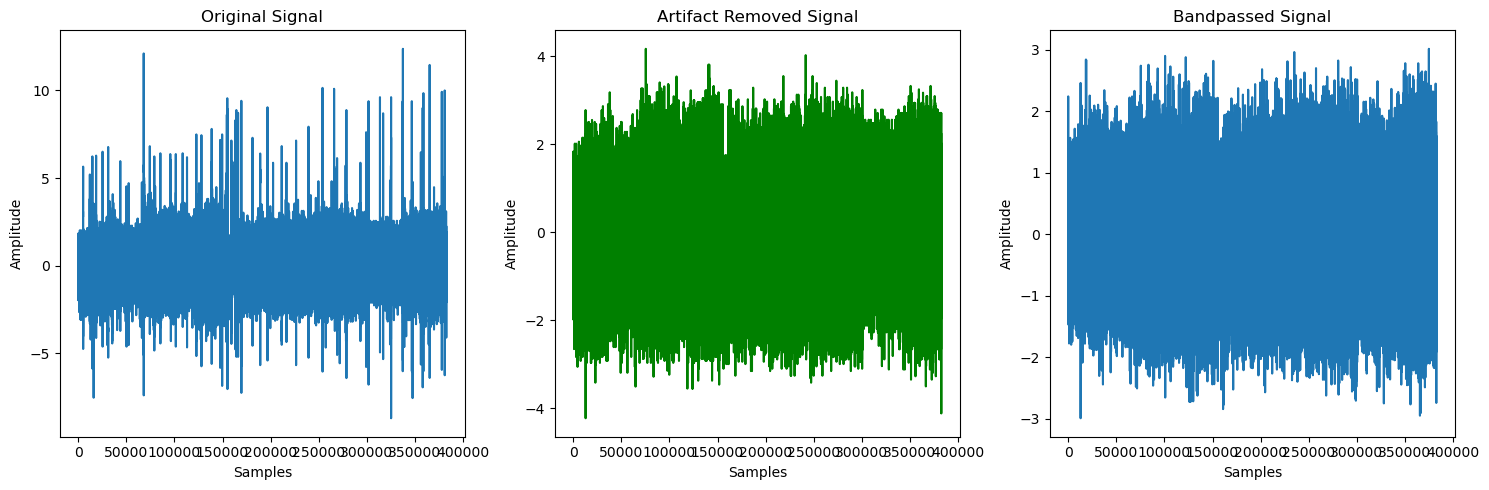

In [6]:
import matplotlib.pyplot as plt

# Plot the original, filtered, and artifact removed signals for comparison
plt.figure(figsize=(15, 5))

# Original signal
plt.subplot(1, 3, 1)
plt.plot(af8['AF8_normal'], label='Original')
plt.title('Original Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')


# Artifact removed signal
plt.subplot(1, 3, 2)
plt.plot(af8['AF8_artif_removed'], label='Artifact Removed', color='green')
plt.title('Artifact Removed Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Original signal
plt.subplot(1, 3, 3)
plt.plot(af8['AF8_bandpassed'], label='Bandpassed')
plt.title('Bandpassed Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

### Separate trials

In [7]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = af8[af8['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = af8[af8['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = af8[af8['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Segmentation

In [8]:
segments_t1 = segment_column(eeg_data_t1['AF8_bandpassed'], gradcpt_data_t1)
segments_t2 = segment_column(eeg_data_t2['AF8_bandpassed'], gradcpt_data_t2)
segments_t3 = segment_column(eeg_data_t3['AF8_bandpassed'], gradcpt_data_t3)

### Rocket with independent instances

In [9]:
# segments = np.array(segments_t2 + segments_t3)
# labels = np.array(pd.concat([gradcpt_data_t2['in_the_zone'], gradcpt_data_t3['in_the_zone']]))

segments = np.array(segments_t1 + segments_t2 + segments_t3)
labels = np.array(pd.concat([gradcpt_data_t1['in_the_zone'], gradcpt_data_t2['in_the_zone'], gradcpt_data_t3['in_the_zone']], ignore_index=True))

# Check the current shape of 'segments'
print(f"Original shape: {segments.shape}")

# Reshape 'segments' to add an extra dimension
reshaped_segments = segments.reshape(segments.shape[0], 1, segments.shape[1])

# Check the new shape
print(f"Reshaped shape: {reshaped_segments.shape}")
print(f"Labels shape: {labels.shape}")

Original shape: (1854, 205)
Reshaped shape: (1854, 1, 205)
Labels shape: (1854,)


In [10]:
from detach_rocket.detach_rocket.detach_classes import DetachRocket
from sklearn.model_selection import train_test_split

X = reshaped_segments
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = DetachRocket(model_type='minirocket', num_kernels=10000)
model.fit(X_train, y_train)

#Evaluate Performance on Test Set
detach_test_score, full_test_score= model.score(X_test,y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach-ROCKET: {:.2f}%'.format(100*detach_test_score))

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 72.38%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 110.00
Train Accuraccy Detach Model: 60.06%
-------------------------
Test Accuraccy Full Model: 59.50%
Test Accuraccy Detach-ROCKET: 54.12%


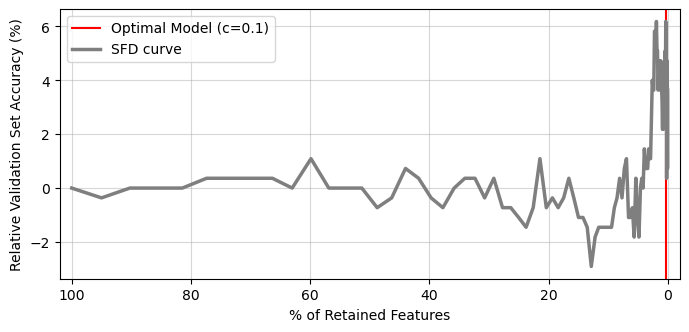

Optimal Model Size: 0.35% of full model


In [11]:
percentage_vector = model._percentage_vector
acc_curve = model._sfd_curve

c = model.trade_off

x=(percentage_vector) * 100
y=(acc_curve/acc_curve[0]-1) * 100
point_x = x[model._max_index]
#point_y = y[DetachRocketModel._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x, y, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))

### Rocket with 4 preceding segments

In [12]:
# Initialize the new segments and labels arrays
new_segments = []
new_labels = []

# Loop through the original segments, starting from the 4th one
for i in range(4, len(segments)):
    # Concatenate the current segment with its 4 preceding segments
    concatenated_segment = np.concatenate(segments[i-4:i+1].reshape(5, 205), axis=0)  # Reshape to (5, 205) and then concatenate along axis 0
    new_segments.append(concatenated_segment)
    
    # Use the label of the current segment for the new concatenated segment
    new_labels.append(labels[i])

# Convert the list of new segments and labels back to numpy arrays
new_segments = np.array(new_segments)
new_labels = np.array(new_labels)

# Reshape new_segments to add the singleton dimension, making its shape (n_instances, 1, 1025)
new_segments = new_segments.reshape(new_segments.shape[0], 1, new_segments.shape[1])

# Check the new shapes
print(f"New reshaped segments shape: {new_segments.shape}")
print(f"New labels shape: {new_labels.shape}")

New reshaped segments shape: (1850, 1, 1025)
New labels shape: (1850,)


In [15]:
from detach_rocket.detach_rocket.detach_classes import DetachRocket
from sklearn.model_selection import train_test_split

X = reshaped_segments
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = DetachRocket(model_type='rocket', num_kernels=10000)
model.fit(X_train, y_train)

#Evaluate Performance on Test Set
detach_test_score, full_test_score= model.score(X_test,y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach-ROCKET: {:.2f}%'.format(100*detach_test_score))

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 615848.21
Train Accuraccy Full ROCKET: 65.14%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 65.00
Train Accuraccy Detach Model: 85.27%
-------------------------
Test Accuraccy Full Model: 56.63%
Test Accuraccy Detach-ROCKET: 52.33%


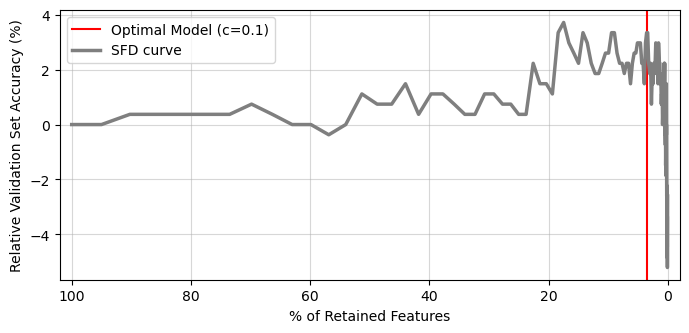

Optimal Model Size: 3.56% of full model


In [16]:
percentage_vector = model._percentage_vector
acc_curve = model._sfd_curve

c = model.trade_off

x=(percentage_vector) * 100
y=(acc_curve/acc_curve[0]-1) * 100
point_x = x[model._max_index]
#point_y = y[DetachRocketModel._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x, y, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))